# Simulation of Lattice model

In condensed matter physics and material science, lattice models are usually described as a (sometimes overly) simplified version of real materials to understand some key aspect of their character, while ignoring the others.

Real materials consist of atoms and associated electrons. The atoms can be arranged in regular pattern to form lattice, or random. The electrons may be tightly bound to their atoms like in an insulator, or delocalised in the entire region like a metal.
Depending on what one wants to study, one makes simplifying assumptions, and constructs a model.

## The model
For example, If one is studying magnetism in an insulator, then one knows that the electrons are tightly bound to an atom and have very little movement. So if we assume electrons movement completely frosen to the atomic site, they behave like a spin.
**Heisenberg model** is such a model, where atomic locations are assumed to be in a periodic lattice, and at each site there exists one spin. This spin in general, can represent collection of all the frozen electrons.
The model is defined in terms of its energy, or Hamiltoniain, and a quantum mechanical model is defined in terms of the energy, or Hamiltonian operator -

$$
H = \sum_{i, j} J_{ij} {\bf S_i}\cdot{\bf S_j}
$$

where ${\bf S_i} = (S_i^x, S_i^y, S_iz)$ is the spin operator for the lattice site labelled ${\bf i}$. The total energy is seen as sum of the dot products of different spins, scaled by the `coupling` energies $J_{ij}$.
A simple and relatable situation is that this coupling is very weak for the sites that are far away, so one can take another assumption that they are zero beyong nearest neighbours.


## The task

The simplest task one wants to know, is what is the ground state of this system, i.e., lowest energy eigenvalue, and eigenstate.

In [1]:
import qiskit
import qiskit_nature as qsn
import matplotlib.pyplot as plt

In [2]:
# import these utterly randomly located components from the module's zoo!

from qiskit_nature.second_q.hamiltonians import heisenberg_model                      # class for Heisenberg model
from qiskit_nature.second_q.hamiltonians.lattices import Lattice, line_lattice        # class for lattice
from qiskit_nature.second_q.hamiltonians.lattice_model import LatticeModel            # class for lattice model
bc = line_lattice.BoundaryCondition.PERIODIC

Following is a visual of a one dimensional lattice with $N$ sites, with periodic boundary condition.

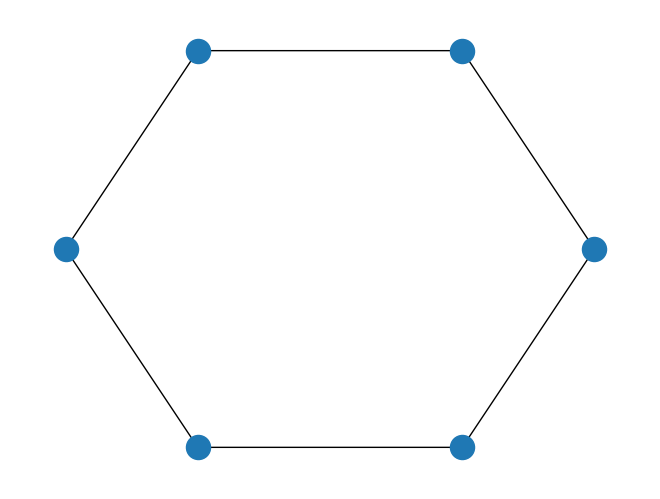

In [5]:
# define a 1d lattice
N = 6
line = line_lattice.LineLattice(N, boundary_condition=bc)
line.draw()

In [6]:
heisenberg_model.Lattice is Lattice, heisenberg_model.LatticeModel is LatticeModel

(True, True)

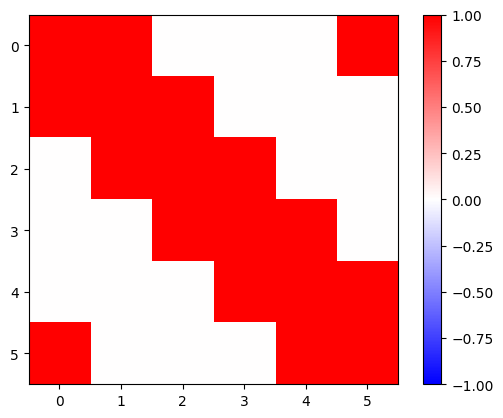

In [7]:
plt.imshow(line.to_adjacency_matrix(), origin='upper', cmap='bwr', vmin=-1, vmax=1);plt.colorbar()

In [8]:
heisen = heisenberg_model.HeisenbergModel(line)

In [9]:
heisen.coupling_constants

(1.0, 1.0, 1.0)

In [10]:
heisen.interaction_matrix().real

array([[0., 1., 0., 0., 0., 1.],
       [1., 0., 1., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 1., 0., 1.],
       [1., 0., 0., 0., 1., 0.]])

In [21]:
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit.circuit.library import EfficientSU2
from qiskit.primitives import Estimator, StatevectorEstimator

# 1. Define Hamiltonian using SparsePauliOp (new in Qiskit 1.0)
def heisenberg_hamiltonian(N, J=1.0):
    paulis = []
    coeffs = []
    for i in range(N-1):
        # XX term
        pauli_str = ["I"] * N
        pauli_str[i] = "X"
        pauli_str[i+1] = "X"
        paulis.append("".join(pauli_str))
        coeffs.append(J)
        # YY term
        pauli_str[i] = "Y"
        pauli_str[i+1] = "Y"
        paulis.append("".join(pauli_str))
        coeffs.append(J)
        # ZZ term
        pauli_str[i] = "Z"
        pauli_str[i+1] = "Z"
        paulis.append("".join(pauli_str))
        coeffs.append(J)
    return SparsePauliOp(paulis, coeffs=coeffs)

# 2. Setup and run VQE
N = 2  # Number of spins/qubits
hamiltonian = heisenberg_hamiltonian(N)

ansatz = EfficientSU2(N, reps=1)
optimizer = COBYLA(maxiter=3000)
estimator = Estimator()  # Use Qiskit's new primitives
#estimator = StatevectorEstimator()  # Use Qiskit's new primitives

vqe = VQE(estimator, ansatz, optimizer)
result = vqe.compute_minimum_eigenvalue(hamiltonian)

print(f"\n\nGround state energy: {result.eigenvalue.real:.10f}\n\n")



Ground state energy: -2.9999942263




/var/folders/kv/j_kv0grs1wj0ws9xc2h5ntjm0000gq/T/ipykernel_90916/3218488367.py:36: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()  # Use Qiskit's new primitives


In [10]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import EfficientSU2
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Estimator  # V2 estimator
import numpy as np

# 1. Define Heisenberg Hamiltonian (unchanged)
def heisenberg_hamiltonian(N, J=1.0):
    paulis = []
    coeffs = []
    for i in range(N-1):
        # XX term
        pauli_str = ["I"] * N
        pauli_str[i] = "X"
        pauli_str[i+1] = "X"
        paulis.append("".join(pauli_str))
        coeffs.append(J)
        # YY term
        pauli_str[i] = "Y"
        pauli_str[i+1] = "Y"
        paulis.append("".join(pauli_str))
        coeffs.append(J)
        # ZZ term
        pauli_str[i] = "Z"
        pauli_str[i+1] = "Z"
        paulis.append("".join(pauli_str))
        coeffs.append(J)
    return SparsePauliOp(paulis, coeffs=coeffs)

# 2. Setup components
N = 2
hamiltonian = heisenberg_hamiltonian(N)
ansatz = EfficientSU2(N, reps=1)
optimizer = COBYLA(maxiter=500)
estimator = StatevectorEstimator()  # V2 primitive

# 3. Manual VQE loop
def objective_function(params):
    # Run estimator with V2 syntax: (circuit, observable, parameters)
    job = estimator.run([(ansatz, hamiltonian, params)])
    return job.result()[0]

initial_point = np.random.random(ansatz.num_parameters)
#result = optimizer.minimize(objective_function, initial_point)

#print(f"Ground state energy: {result.fun:.4f}")

In [11]:
x = objective_function(initial_point)

In [12]:
x.data.evs

array(0.77986856)

In [15]:
qc = qiskit.QuantumCircuit(N)
qc.compose(ansatz, inplace=True)
qc.draw()

┌────────────────────────────────────────────────────────┐
q_0: ┤0                                                       ├
     │  EfficientSU2(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7]) │
q_1: ┤1                                                       ├
     └────────────────────────────────────────────────────────┘